## Overview
- This notebook demonstrates stopping rules included in `trieste_stopping`.
- We first define a test case and then overview API and individual stopping rules.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

tf.random.set_seed(0)

## Build a test case

#### Place a Gaussian process prior on functions $f : \mathcal{X} \to \mathbb{R}$

In [2]:
from gpflow.kernels import Matern52
from gpflow.likelihoods import Gaussian
from trieste.data import Dataset
from trieste.space import Box

space = Box(lower=[0], upper=[1])  # \mathcal{X} := [0, 1]^D
kernel = Matern52(lengthscales=0.25)
likelihood = Gaussian(variance=1e-5)

#### Sample a test function from the prior

In [3]:
from trieste_stopping.models import draw_kernel_feature_map, LinearTrajectory

feature_map = draw_kernel_feature_map(kernel, space.dimension)
test_weights = tf.random.normal([*feature_map.event_shape, 1], dtype=tf.float64)
test_function = LinearTrajectory(feature_map, test_weights)

#### Initialize a model with some random observation

In [4]:
from gpflow.models import GPR
from trieste.models.gpflow import GaussianProcessRegression

X = space.sample_sobol(10)
Y = tf.add(
    test_function(X),
    tf.sqrt(likelihood.variance) * tf.random.normal([len(X), 1], dtype=tf.float64)
)
model = GaussianProcessRegression(GPR(data=(X, Y), kernel=kernel, likelihood=likelihood))
train_set = Dataset(X, Y)

## Stopping rules
- The general interface is modeled after `trieste.acquisition`.
- `StoppingCriterion` classes are responsible for testing whether a stopping condition holds.
- `StoppingRule` classes manage `StoppingCriterion` instances and act as a bridge of sorts.
- `StoppingCriterion` instances come equipped with an `IncumbentRule` for choosing a best solution.
- The default incumbent rule is `InSamplePosteriorMinimizer`, which choosing a queried point that minimizes the posterior mean.

### Fixed Budget
- References: Not Applicable
- This rule stops when a given number of observations have been made.
- We first show the high-level API.
- When called, a `StoppingCriterion` or `StoppingRule` returns a `StoppingData` dataclass with fields:
    - `done`: 0-1 indicator for whether we should stop.
    - `value`: The (optimal) value of the stopping criterion.
    - `incumbent`: A dataclass summarizing the recommended solution.
    - `setup_time`: The amount of time spent evaluating the criterion.

In [5]:
from trieste_stopping.stopping import FixedBudget

budget = FixedBudget(budget=10)
budget(model=model, space=space, dataset=train_set)

StoppingData(done=1, value=nan, incumbent=IncumbentData(point=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.05459595])>, observation=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.15411995])>, index=<tf.Tensor: shape=(), dtype=int64, numpy=8>, mean=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.15394079])>, variance=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([9.93522101e-06])>), setup_time=0.011143583047669381)

### Acquisition Threshold
- References: [[Jones, 2001]](https://research.cs.wisc.edu/areas/ai/airg/jones01taxonomy.pdf) and [[Nguyen et. al, 2017]](https://proceedings.mlr.press/v77/nguyen17a.html).
- This rule stop when the maximum acquisition value drops below a given threshold.

In [6]:
from trieste.acquisition import EfficientGlobalOptimization
from trieste_stopping.stopping import AcquisitionThreshold

acq = AcquisitionThreshold(  # the EGO class defaults to using EI
    acquisition_rule=EfficientGlobalOptimization(), threshold=1e-5,
)
acq(model=model, space=space, dataset=train_set)

StoppingData(done=0, value=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.01119762])>, incumbent=IncumbentData(point=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.05459595])>, observation=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.15411995])>, index=<tf.Tensor: shape=(), dtype=int64, numpy=8>, mean=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.15394079])>, variance=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([9.93522101e-06])>), setup_time=1.503012084052898)

### Confidence Bound
- Reference: [[Makarova et. al, 2022]](https://arxiv.org/abs/2104.08166).
- This rule stops when the different between upper and lower confidence bounds is less than or equal to a regret bound $\epsilon$, i.e.
\begin{align}
  \min_{\boldsymbol{x} \in \mathbf{X}} \operatorname{UCB}_t(x)
  - \min_{\boldsymbol{x}' \in \mathcal{X}} \operatorname{LCB}_t(x) \le \epsilon
\end{align}
where $\operatorname{[U/L]CB}_t(\boldsymbol{x}) = \mu(\boldsymbol{x}) \pm \sqrt{\beta_t k_t(\boldsymbol{x}, \boldsymbol{x})}$ for $\mu_t$ and $k_t$ defined as posterior mean and covariance functions, respectively.

In [7]:
from math import log, pi
from trieste_stopping.stopping import ConfidenceBound

dim = int(space.dimension)
ucb_rule = ConfidenceBound(
    regret_bound=0.1,
    beta_schedule=lambda step:(2 / 5) * log((step * pi) ** 2 * dim / (6 * 0.05)),  # see reference
)
ucb_rule(model=model, dataset=train_set, space=space)

StoppingData(done=1, value=<tf.Tensor: shape=(), dtype=float64, numpy=0.055496118990700394>, incumbent=IncumbentData(point=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.05459595])>, observation=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.15411995])>, index=<tf.Tensor: shape=(), dtype=int64, numpy=8>, mean=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.15394079])>, variance=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([9.93522101e-06])>), setup_time=0.5228710829978809)

### Probabilistic Regret Bound
- Reference: [[Wilson, 2024]](???).
- This rule stops when a point has been found whose value is within $\epsilon > 0$ of the best possible outcome with probability at least $1 - \delta$ under the model, i.e.
\begin{align}
\min_{\boldsymbol{x} \in \mathbf{X}} \mathbb{P}\left(f(x) - \inf_{\boldsymbol{x}' \in \mathcal{X}} f(x') \ge \epsilon\right) \le \delta.
\end{align}
-  The risk tolerance $\delta$ is split between two terms, $\delta_{\textrm{mod}}$ and $\delta_{\textrm{est}}$, so that
    -  $\delta_{\textrm{mod}}$ upper bounds the probability that a returned point is not within $\epsilon > 0$ of the best possible outcome under the model.
    -  $\delta_{\textrm{est}}$ upper bounds the probability of a false positive occuring due to estimation error.
    -  In practice, $\delta_{\textrm{est}}$ is usually divided among steps $t = 1, \ldots T$.

In [8]:
from trieste_stopping.stopping import ProbabilisticRegretBound

prb_rule = ProbabilisticRegretBound(
    regret_bound=0.1,  # \epsilon
    risk_tolerance_model=0.025,  # this is \delta_{mod}, 
    risk_tolerance_error=0.025,  # converted into a schedule for the value of \delta_{est} at steps t=1,...T
    popsize_limit=1000,  # use no more than 1000 samples
    use_unconverged_estimates=True,  # allow unconverged estimates to be used when deciding whether to stop
)

prb_rule(model=model, dataset=train_set, space=space)

StoppingData(done=1, value=<tf.Tensor: shape=(), dtype=float64, numpy=0.013>, incumbent=IncumbentData(point=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.05459595])>, observation=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.15411995])>, index=<tf.Tensor: shape=(), dtype=int64, numpy=8>, mean=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.15394079])>, variance=<tf.Tensor: shape=(1,), dtype=float64, numpy=array([9.93522101e-06])>), setup_time=46.56564295804128)

## Visuals
- Below, we plot confidence bound and probabilistic regret bound criteria on a test set.
- We will use this example to unpack the high-level API shown above.
- Instead of directly calling the `StoppingRule`, we will construct a `StoppingCriterion` instance and use `StoppingCriterion.evaluate`.

In [9]:
def plot_posterior(ax, model, points):
    means, variances = map(tf.squeeze, model.predict(points))
    ax.plot(points, means)
    ax.fill_between(
        tf.squeeze(points, axis=-1),
        means - 2 * tf.sqrt(variances), 
        means + 2 * tf.sqrt(variances), 
        alpha=0.2
    )

    train_set = model.get_internal_data()
    ax.scatter(train_set.query_points, train_set.observations, c="k", zorder=9)
    ax.plot(points, test_function(points), "--k", zorder=9)
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    

test_set = Dataset(
    query_points=tf.cast(tf.linspace(0, 1, 100)[:, None], tf.float64),
    observations=tf.fill((100, 1), float("nan")),  # unused
)

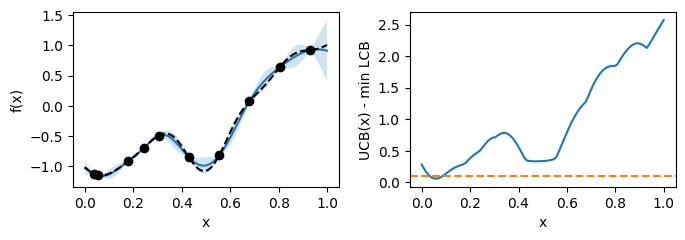

In [10]:
ucb_criterion = ucb_rule.prepare_stopping_criterion(model=model, dataset=train_set)
cb_differences = ucb_criterion.evaluate(space=space, dataset=test_set)

fig, axes = plt.subplots(figsize=(7, 2.5), ncols=2)
plot_posterior(axes[0], model, test_set.query_points)
axes[1].plot(test_set.query_points, cb_differences);
axes[1].axhline(ucb_criterion.regret_bound, color="tab:orange", linestyle="--")
axes[1].set_xlabel("x")
axes[1].set_ylabel("UCB(x) - min LCB")
plt.tight_layout()

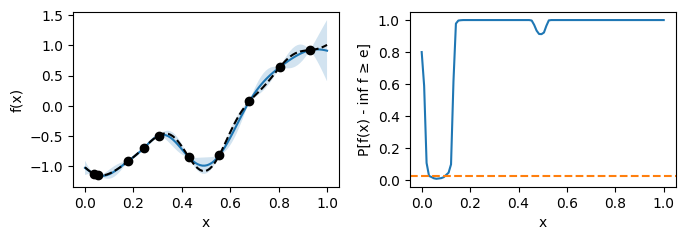

In [11]:
prb_criterion = prb_rule.prepare_stopping_criterion(model=model, dataset=train_set)
prb_estimates, _ = prb_criterion.evaluate(space=space, dataset=test_set, prune=False)

fig, axes = plt.subplots(figsize=(7, 2.5), ncols=2)
plot_posterior(axes[0], model, test_set.query_points)
axes[1].plot(test_set.query_points, prb_estimates)
axes[1].axhline(prb_criterion.risk_tolerance_model, color="tab:orange", linestyle="--")
axes[1].set_xlabel("x")
axes[1].set_ylabel("P[f(x) - inf f ≥ e]")
plt.tight_layout()